## Feature Selection Chi^2

## Imports

In [1]:
# System functionality
import sys
sys.path.append('..')

import glob
import os
import numpy as np 
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import seaborn as sns
import graphviz
import math as math
import json
import cv2
import scipy.stats as stats
import matplotlib.image as mpimg
import sklearn.feature_selection as feature_selection
from skimage import data, io, filters
from numpy import linspace
from numpy.core.umath import pi
from matplotlib.ticker import FuncFormatter
from matplotlib.font_manager import FontProperties
from emoji_extractor.extract import Extractor
from emojipedia import Emojipedia
from skimage import io
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import chi2_contingency
from scipy.interpolate import spline

## Load

In [2]:
# Random Sample (2.5M tweets)
path = '/home/stelios/Desktop/Honours Project/Samples/random_sample_worldwide_2500000.csv'
ran_join_df = pd.read_csv(path,index_col=None, header=0, low_memory = False).applymap(str)

## Bar Chart Formatters

In [3]:
# Millions Formatter Function
def millions(x,pos):
    return '%1.1fK' % (x*1e-3)

# Power of 10 Formatter Function (y log scale bug, so i have created this formatter)
def pow10(x,pos):
    return "{:.0f}\n10 ".format(x)

# Power of 10 (1 d.p) Formatter Function (y log scale bug, so i have created this formatter)
def pow10_1dp(x,pos):
    return "{:.1f}\n10     ".format(x)

# Percenatge Formatter Function
def percentage(x,pos):
    return "{:.1f}%".format(x*100)

# Create a formatters
formatter_millions = FuncFormatter(millions)
formatter_pow10 = FuncFormatter(pow10)
formatter_pow10_1dp = FuncFormatter(pow10_1dp)
formatter_percentage = FuncFormatter(percentage)

# Use TwitterColorEmoji Font (only one supporting emojis) 
emojis_font = FontProperties(fname='./Fonts/TwitterColorEmoji-SVGinOT.ttf',size=55)

## Colours

In [4]:
colors_seagreen_fade=["#f3f8f3","#e8f1e8","#ddeadd","#d2e4d2","#c7ddc7","#bbd6bb","#b0d0b0","#a5c9a5","#9ac29a","#8fbc8f","#80a980","#729672","#648364","#557055","#475e47","#394b39"]

colors_orange_fade=["#fff6e5","#ffedcc","#ffe4b2","#ffdb99","#ffd27f","#ffc966","#ffc04c","#ffb732","#ffae19","#ffa500","#e59400","#cc8400","#b27300","#996300","#7f5200","#664200"]

colors_dodgeblue_fade=["#e7f1fa","#d0e3f5","#b9d5f0","#a2c7eb","#8bb9e6","#74abe1","#5d9ddc","#468fd7","#2f81d2","#1874cd","#1568b8","#135ca4","#10518f","#0e457b","#0c3a66","#092e52"]

colors_indianred_fade=["#faeeee","#f5dddd","#f0cccc","#ebbbbb","#e6aaaa","#e19999","#dc8888","#d77676","#d26666","#cd5555","#b84c4c","#a44444","#8f3b3b","#7b3333","#662a2a","#522222"]

## Emojis on Bar Chart Function

In [5]:
def bar_chart_plot_emojis(ax,fig,x,y):
    # Set sizes of figure and images
    ax_width = ax.get_window_extent().width
    fig_width = fig.get_window_extent().width
    fig_height = fig.get_window_extent().height
    img_size = ax_width/(fig_width*len(x_linespace))
    img_axs = [None for i in range(len(x_linespace))]
    
    ##delete
    #a = io.imread(Emojipedia.search(x[1]).platforms[5].image_url)

    # Display emojis pngs on x-axis
    for i in range(len(x)):
        loc = ax.transData.transform((x_linespace[i], y[i]))      # Optimize y manually 
        img_axs[i] = fig.add_axes([loc[0]/fig_width-img_size/2, loc[1]/fig_height-img_size/2,
                                   img_size, img_size], anchor='C')

        # Platform 5 = Twitter
        img_axs[i].imshow(io.imread(Emojipedia.search(x[i]).platforms[5].image_url))
        img_axs[i].axis("off")
        
        ##delete
        #img_axs[i].imshow(a)
        #img_axs[i].axis("off")

## Count

In [6]:
extract = Extractor()
count = extract.count_all_emoji(ran_join_df['text'])

## Extract Emojis for All

In [7]:
# Create panda dataframe to store emojis with counts
emojis_count_df = pd.DataFrame(columns = ['Emoji','Count'])
for emoji in count:
    emojis_count_df = emojis_count_df.append({'Emoji' : emoji , 'Count' : count[emoji]} , ignore_index=True)

# Sort dataframe by count
emojis_count_df = emojis_count_df.sort_values(by=['Count'])

# Print size of tweets
print(len(ran_join_df['text']))

# Show last 20 (sorted)
emojis_count_df.tail(20)

2500000


Emoji   Count
6       💖    7449
40      🙄    8273
102     ♥    8488
66      🙏    8526
50      💙    8630
35      👍    8731
46      😘    9270
19      👏   10426
26      🤔   11191
61      🔥   11648
22      💜   11917
42      😊   12812
1       ✨   17498
43      💕   19626
12      ♻   20418
30      🤣   22041
41      😍   31602
8       ❤   43497
11      😭   58342
0       😂  145789

## Emoji frequencies per tweet

In [8]:
length_emojis = len(emojis_count_df['Emoji'].values)
print(length_emojis)
length_tweets = len(ran_join_df['text'])

# Avoid Low Memory Error
from scipy.sparse import *
from scipy import *
zeros_matrix = csr_matrix( (length_tweets,length_emojis), dtype=int8 ).todense()

# Fill pandas dataframe with zeros
emojis_count_create_df = pd.DataFrame(zeros_matrix,columns = emojis_count_df['Emoji'].values)
emojis_count_create_df

#countloop =0
extract = Extractor()

# Add the frequencies of each emoji by Tweet
for enum,text in enumerate (ran_join_df['text']):
    #countloop = countloop+1
    #print(countloop)
    text_count_emoji = extract.count_emoji(text, check_first=True)
    if(len(text_count_emoji)==0):
        #print("Non")
        pass
    else:
        for emoji in text_count_emoji:
            #print(emoji)
            emojis_count_create_df.at[enum, emoji] = text_count_emoji[emoji]
# Describe throws memory error
##emojis_count_create_df.describe() 
emojis_count_create_df.info(memory_usage='deep')

2033
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500000 entries, 0 to 2499999
Columns: 2033 entries, 🇮🇨 to 😂
dtypes: int8(2033)
memory usage: 4.7 GB


## ChiSquare Class

In [9]:
class ChiSquare:
    
    def __init__(self, dataframe):
        self.df = dataframe
        self.p = None #P-Value
        self.chi2 = None #Chi Test Statistic
        self.dof = None
        self.dfObserved = None
        self.dfExpected = None
        
    def _print_chisquare_result(self, colX, alpha,emoji_dictionary):
        result = ""
        if self.p<alpha:
            result="{0} is IMPORTANT".format(colX)
            
        else:
            result="{0} is NOT an important".format(colX)
        #print("{}  {}".format(result,self.p))
        emoji_dictionary[colX]=self.p
    
    def TestIndependence(self,colX,colY,emoji_dictionary, alpha=0.05):
        X = self.df[colX].astype(str)
        Y = self.df[colY].astype(str)
        
        self.dfObserved = pd.crosstab(Y,X) 
        chi2, p, dof, expected = stats.chi2_contingency(self.dfObserved.values)
        self.p = p
        self.chi2 = chi2
        self.dof = dof 
        
        self.dfExpected = pd.DataFrame(expected, columns=self.dfObserved.columns, index = self.dfObserved.index)
        #print("{} ".format(chi2))
        self._print_chisquare_result(colX,alpha,emoji_dictionary)

## Add (Asians vs Not Asians) on Table

In [10]:
## Avoid an error with assignment
pd.options.mode.chained_assignment = None

## Drop Ethnicity and add (asian, not asian)
emojis_count_create_df['ethnicity']= ran_join_df['ethnicity']
emojis_count_create_df.ethnicity[emojis_count_create_df.ethnicity!="asian"] = "not asian"

In [11]:
emojis_count_create_df

🇮🇨  ⏯  👨🏼‍⚕️  👨🏼  🧛🏼‍♀️  🈹  🏌🏾‍♂️  👩🏻‍🎤  👳🏻  🧙🏼‍♂️    ...      😊  ✨  \
0         0  0      0   0      0  0      0     0   0      0    ...      0  0   
1         0  0      0   0      0  0      0     0   0      0    ...      0  0   
2         0  0      0   0      0  0      0     0   0      0    ...      0  0   
3         0  0      0   0      0  0      0     0   0      0    ...      0  0   
4         0  0      0   0      0  0      0     0   0      0    ...      0  1   
5         0  0      0   0      0  0      0     0   0      0    ...      0  0   
6         0  0      0   0      0  0      0     0   0      0    ...      0  0   
7         0  0      0   0      0  0      0     0   0      0    ...      0  0   
8         0  0      0   0      0  0      0     0   0      0    ...      0  0   
9         0  0      0   0      0  0      0     0   0      0    ...      0  0   
10        0  0      0   0      0  0      0     0   0      0    ...      0  0   
11        0  0      0   0      0  0      0     0   0      0    ...      0  0   
12        0  0      0   0      0  0      0     0   0      0    ...      0  0   
13        0  0      0   0      0  0      0     0   0      0    ...      0  0   
14        0  0      0   0      0  0      0     0   0      0    ...      0  0   
15        0  0      0   0      0  0      0     0   0      0    ...      0  0   
16        0  0      0   0      0  0      0     0   0      0    ...      0  0   
17        0  0      0   0      0  0      0     0   0      0    ...      0  0   
18        0  0      0   0      0  0      0     0   0      0    ...      0  0   
19        0  0      0   0      0  0      0     0   0      0    ...      0  0   
20        0  0      0   0      0  0      0     0   0      0    ...      0  0   
21        0  0      0   0      0  0      0     0   0      0    ...      0  0   
22        0  0      0   0      0  0      0     0   0      0    ...      0  0   
23        0  0      0   0      0  0      0     0   0      0    ...      0  0   
24        0  0      0   0      0  0      0     0   0      0    ...      0  0   
25        0  0      0   0      0  0      0     0   0      0    ...      0  0   
26        0  0      0   0      0  0      0     0   0      0    ...      0  0   
27        0  0      0   0      0  0      0     0   0      0    ...      0  0   
28        0  0      0   0      0  0      0     0   0      0    ...      0  0   
29        0  0      0   0      0  0      0     0   0      0    ...      0  0   
...      .. ..    ...  ..    ... ..    ...   ...  ..    ...    ...     .. ..   
2499970   0  0      0   0      0  0      0     0   0      0    ...      0  0   
2499971   0  0      0   0      0  0      0     0   0      0    ...      0  0   
2499972   0  0      0   0      0  0      0     0   0      0    ...      0  0   
2499973   0  0      0   0      0  0      0     0   0      0    ...      0  0   
2499974   0  0      0   0      0  0      0     0   0      0    ...      0  0   
2499975   0  0      0   0      0  0      0     0   0      0    ...      0  0   
2499976   0  0      0   0      0  0      0     0   0      0    ...      0  0   
2499977   0  0      0   0      0  0      0     0   0      0    ...      0  0   
2499978   0  0      0   0      0  0      0     0   0      0    ...      0  0   
2499979   0  0      0   0      0  0      0     0   0      0    ...      0  0   
2499980   0  0      0   0      0  0      0     0   0      0    ...      0  0   
2499981   0  0      0   0      0  0      0     0   0      0    ...      0  0   
2499982   0  0      0   0      0  0      0     0   0      0    ...      0  0   
2499983   0  0      0   0      0  0      0     0   0      0    ...      0  0   
2499984   0  0      0   0      0  0      0     0   0      0    ...      0  0   
2499985   0  0      0   0      0  0      0     0   0      0    ...      0  0   
2499986   0  0      0   0      0  0      0     0   0      0    ...      0  0   
2499987   0  0      0   0      0  0      0     0   0      0    ...      0  0   
2499988  

## Chi Sqaure Asians vs Not Asians

In [12]:
#Initialize ChiSquare Class
cTasian = ChiSquare(emojis_count_create_df)

#Feature Selection
emoji_dict={}
for emoji in emojis_count_df['Emoji'].values:
    cTasian.TestIndependence(colX=emoji,colY="ethnicity",emoji_dictionary=emoji_dict)
print("Done 1")
# Mean for asian(+) - Mean for non asian(-)
mean_asian = emojis_count_create_df.loc[emojis_count_create_df['ethnicity'] == 'asian'].mean() - emojis_count_create_df.loc[emojis_count_create_df['ethnicity'] == 'not asian'].mean()
mean_asian_dict = mean_asian.to_dict()
print("Done 2")
# Sorted by uncorrelated
sorted_by_value_asian = sorted(emoji_dict.items(), key=lambda kv: kv[1])
print("Done 3")
# Dictionary sorted by uncorrelated emojis with gender
sorted_asian = {}
for key,value in sorted_by_value_asian:
    for key2 in mean_asian_dict:
        if(key==key2):
            if(mean_asian_dict[key2]>0):
                sorted_asian[key]='asian'
            elif(mean_asian_dict[key2]<0):
                sorted_asian[key]='not asian'
            else:
                sorted_asian[key]='Same'
print("Done 4")                
# Dataframe to plot
df_to_plot_asian = pd.DataFrame(data=sorted_by_value_asian,columns=['Emoji','P-value'])
df_to_plot_asian['ethnicity'] = sorted_asian.values()
df_to_plot_asian

Done 1
Done 2
Done 3
Done 4


Emoji        P-value  ethnicity
0         ⏩   0.000000e+00      asian
1         ◀   0.000000e+00      asian
2         😆   0.000000e+00      asian
3         💗   0.000000e+00      asian
4         ✨   0.000000e+00      asian
5         💕  1.319808e-280      asian
6         💜  1.410169e-272      asian
7         ❓  1.406151e-264      asian
8         🦊  4.497479e-171      asian
9         😭  2.851032e-169      asian
10        ♻  3.827170e-166  not asian
11        🐽  2.390886e-147      asian
12        ❗  3.736615e-142      asian
13        ☺  1.809634e-128      asian
14        ♂  2.640445e-124      asian
15        ©  2.018496e-121      asian
16        ❤  2.029046e-109      asian
17        🍀   6.079146e-73      asian
18        🎵   1.259316e-72      asian
19        🐹   1.008383e-71      asian
20        😁   8.401410e-68      asian
21        🌟   5.971249e-65      asian
22        💓   8.580493e-64      asian
23        🥡   1.025143e-53      asian
24        😝   6.418945e-48      asian
25     🙇‍♀️   3.688638e-44      asian
26        💄   8.264444e-40      asian
27        💚   6.014722e-39      asian
28        🐤   3.255997e-38      asian
29        ♥   5.464809e-34      asian
...     ...            ...        ...
2003      🍝   9.946905e-01  not asian
2004      🐄   9.947022e-01  not asian
2005     🏃🏿   9.947091e-01  not asian
2006  🤸🏾‍♂️   9.947091e-01  not asian
2007      💙   9.947227e-01  not asian
2008      🎀   9.947553e-01  not asian
2009      ♨   9.948604e-01  not asian
2010      🔘   9.950960e-01  not asian
2011      🎸   9.957034e-01  not asian
2012     🇩🇴   9.957908e-01  not asian
2013     🇪🇬   9.958556e-01  not asian
2014      🗽   9.968772e-01  not asian
2015      🚙   9.969566e-01  not asian
2016      🥔   9.969603e-01  not asian
2017      👁   9.974353e-01  not asian
2018      🤤   9.975056e-01  not asian
2019      🌮   9.976432e-01  not asian
2020      🥳   9.980279e-01  not asian
2021   🧟‍♂️   9.982007e-01  not asian
2022      💴   9.982249e-01  not asian
2023      👴   9.984926e-01  not asian
2024      🤝   9.986497e-01  not asian
2025      🥕   9.987793e-01  not asian
2026     🤙🏻   9.988233e-01  not asian
2027      💿   9.988538e-01  not asian
2028      🍤   9.989819e-01  not asian
2029      ✋   9.993199e-01  not asian
2030   🙋‍♀️   9.995046e-01      asian
2031      🎗   9.997927e-01  not asian
2032      🅰   9.999286e-01  not asian

[2033 rows x 3 columns]

In [13]:
df_to_plot_asian.to_csv("/home/stelios/Desktop/Honours Project/Emojis-usage-in-social-media-by-demographics/Jupyter/P-values/chi2_random_asian_pvalues.csv",encoding='utf-8', index=False)
del df_to_plot_asian

## Top 20 Distinct Emojis by Asians

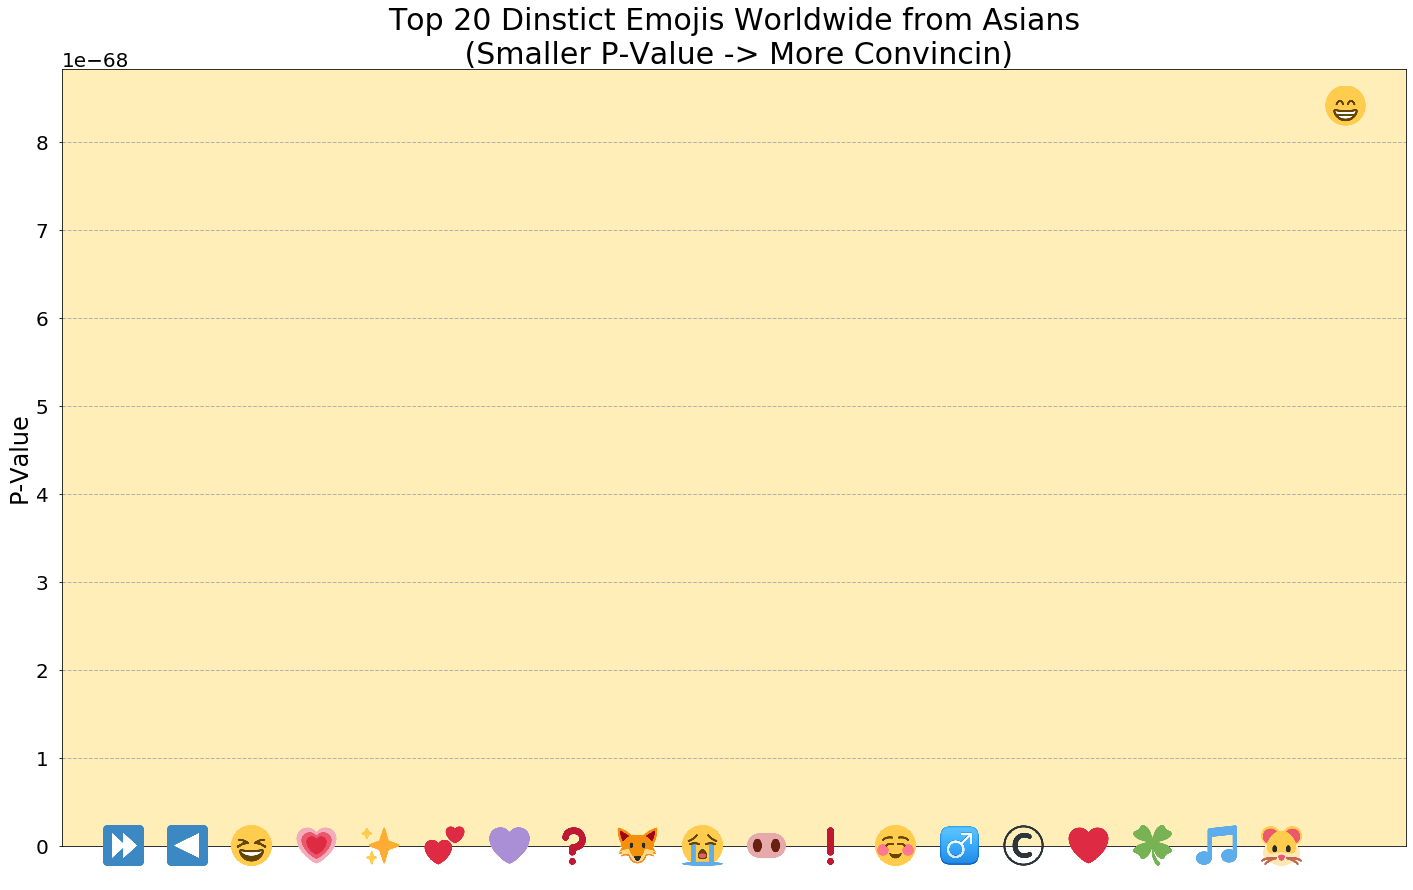

In [16]:
# Read from saved csv
df_to_plot_asian_path = '/home/stelios/Desktop/Honours Project/Emojis-usage-in-social-media-by-demographics/Jupyter/P-values/chi2_random_asian_pvalues.csv'
df_to_plot_asian = pd.read_csv(df_to_plot_asian_path,index_col=None, header=0, low_memory = False)

# Top 20 Values
x=[]
y=[]
counter_20 = 0
for index, row in df_to_plot_asian.iterrows():
    if(row['ethnicity']=='asian'):
        counter_20 = counter_20 +1 
        x.append(row['Emoji'])
        y.append(row['P-value'])
        if(counter_20 ==20):
            break

# Set linespacing
x_linespace = linspace(0, 4*pi, num=20)

# Plot Chart
fig, ax = plt.subplots(figsize=(20,12))
ax.tick_params(axis='both', which='major', pad=10)
ax.set_facecolor('#{}'.format("ffeeb7"))
plt.grid(linestyle='--', linewidth=1,axis='y')
plt.plot(x_linespace, y,linewidth=0,color = 'grey',linestyle=':')
ax.get_xaxis().set_visible(False)
plt.yticks(fontsize =20)
plt.ylabel('P-Value', fontsize =24)
plt.title('Top 20 Dinstict Emojis Worldwide from Asians\n (Smaller P-Value -> More Convincin)', fontsize =30)
plt.tight_layout()

# Change offest size
ax.yaxis.offsetText.set_fontsize(20)

# Set y-lim to 0
ax.set_ylim(bottom=0)

# Plot emojis on x-axis
bar_chart_plot_emojis(ax,fig,x,y)
plt.show()